In [1]:
import sys
import os
import pandas as pd
import numpy as np
from importlib import reload
import heapq

from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csgraph
from skimage.transform import resize

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.visualization import generalPlots as _plot
from utils.trackmate import spatialAnalysis as _stat

/home/cstansbu/.local/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
reload(_tm)
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/test/scene_test/"

data = _tm.load_trackmate_dir(ROOT_DIR)
df = _tm.merge_tracks_and_all(data)

df = _tm.clean_up_trackSpots(df)
df.head()

All shape: (494833, 31)
Links shape: (445654, 16)
Track shape: (27648, 45)
Spots shape: (473302, 31)
merged shape: (473302, 75)
cleaned shape (473302, 66)


,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,TRACK_MAX_QUALITY,TRACK_MIN_QUALITY,TRACK_MEDIAN_QUALITY,TRACK_STD_QUALITY,STEP,NORMED_STEP,MEAN_INTENSITY01_SCALED,MEAN_INTENSITY02_SCALED,MEAN_INTENSITY03_SCALED,MEAN_INTENSITY_SCALED
0,ID40960,40960,0,0.015,3174.383,2165.295,0,0,0,6.5,...,0.016,0.006,0.012,0.003,0,0.000000,0.428571,0.963636,0.18750,0.963636
3215,ID59143,59143,0,0.014,3167.023,2162.450,0,1,1,6.5,...,0.016,0.006,0.012,0.003,1,0.041667,0.333333,0.872727,0.56250,0.872727
4867,ID33628,33628,0,0.012,3158.284,2162.444,0,2,2,6.5,...,0.016,0.006,0.012,0.003,2,0.083333,0.238095,0.563636,0.65625,0.563636
8720,ID44539,44539,0,0.016,3156.800,2163.860,0,3,3,6.5,...,0.016,0.006,0.012,0.003,3,0.125000,0.142857,1.000000,0.75000,1.000000
10888,ID7707,7707,0,0.013,3158.090,2164.785,0,4,4,6.5,...,0.016,0.006,0.012,0.003,4,0.166667,0.619048,0.745455,0.28125,0.745455


In [7]:

new_rows = []

for frame in df['FRAME'].unique():
    sub = df[df['FRAME'] == frame]
    
    t = sub[['POSITION_X', 'POSITION_Y']].to_numpy()
    
    A = squareform(pdist(sub[['POSITION_X', 'POSITION_Y']].to_numpy()))
    L = csgraph.laplacian(A, normed=True)    
    L = resize(L, (500, 500))
    
    eig_values, eig_vectors = np.linalg.eigh(L)
    eig_values = eig_values[eig_values > 0]
        
    fied = heapq.nsmallest(2, eig_values)[-1]
    norm_fied = fied / len(sub)
    
    row = {
        'frame' : frame,
        'n_cells': A.shape[0],
        'mean_distance': A.mean(),
        'fiedler': fied,
        'norm_fiedler': norm_fied,
    }
    
    new_rows.append(row)

    
res = pd.DataFrame(new_rows)
res.head()

,frame,n_cells,mean_distance,fiedler,norm_fiedler
0,0,2132,1668.460395,0.100783,0.000047
1,1,2250,1678.302475,0.091148,0.000041
2,2,2256,1669.862573,0.091182,0.000040
3,3,2276,1660.845765,0.090260,0.000040
4,4,2170,1657.537188,0.097673,0.000045


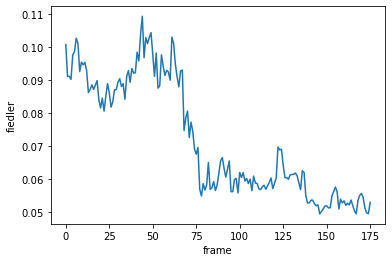

In [8]:
sns.lineplot(data=res, x='frame', y='fiedler')